In [1]:
import numpy as np
import pandas as pd

# pd.set_option('display.height', 1000)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
pd.set_option("max_colwidth", 200)
from IPython.core.display import HTML, display

display(HTML("<style>.container { width:100% !important; }</style>"))


def df_stats(df):
    from tabulate import tabulate

    print("\n***** Shape: ", df.shape, " *****\n")

    columns_list = df.columns.values.tolist()
    isnull_list = df.isnull().sum().values.tolist()
    isunique_list = df.nunique().values.tolist()
    dtypes_list = df.dtypes.tolist()

    list_stat_val = list(zip(columns_list, isnull_list, isunique_list, dtypes_list))
    df_stat_val = pd.DataFrame(list_stat_val, columns=["Name", "Null", "Unique", "Dtypes"])
    print(tabulate(df_stat_val, headers="keys", tablefmt="psql"))
    return df.head()

/tmp/ipykernel_4676/1374276192.py:9: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display


In [2]:
df_dataset = pd.read_csv("data/reports/reports_sampled_no_conclusion.csv", sep='α')

/tmp/ipykernel_4676/1062137522.py:1: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  df_dataset = pd.read_csv("data/reports/reports_sampled_no_conclusion.csv", sep='α')


In [3]:
display(df_dataset.coronary_dominance.value_counts())

coronary_dominance
right_dominant    144220
left_dominant      13616
Name: count, dtype: int64

In [4]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# 1) Dictionary for vessel substrings
labels_to_vessel_names = {
    "lad_stenosis": "left anterior descending (lad)",
    "dist_lad_stenosis": "distal segment of the left anterior descending (lad)",
    "mid_lad_stenosis": "mid segment of the left anterior descending (lad)",
    "lcx_stenosis": "left circumflex (lcx)",
    "dist_lcx_stenosis": "distal branch of the left circumflex (lcx)",
    "leftmain_stenosis": "left main coronary artery (lmca)",
    "prox_rca_stenosis": "proximal right coronary artery (rca)",
    "mid_rca_stenosis": "mid portion of the right coronary artery (rca)",
    "dist_rca_stenosis": "distal portion of the right coronary artery (rca)",
    "posterolateral_stenosis": "posterolateral branch",
    "pda_stenosis": "posterior descending artery (pda)",
}

def parse_report_to_numeric_stenoses(report_text, labels_map):
    """
    Parses an angiography textual report and returns a dictionary containing
    numeric stenosis values and coronary dominance.
    """
    parsed_dict = {lbl: None for lbl in labels_map.keys()}
    parsed_dict["coronary_dominance"] = None

    sentences = report_text.split(".")
    # Regex capturing e.g. "~70" or "(40.0" if "stenosis" is in the line
    stenosis_regex = re.compile(r"(?:~|\()?(\d+(?:\.\d+)?)")

    for sentence in sentences:
        line = sentence.strip()
        if not line:
            continue

        lower_line = line.lower()

        # Check dominance
        if "the coronary circulation is" in lower_line:
            if "right dominant" in lower_line:
                parsed_dict["coronary_dominance"] = "right_dominant"
            elif "left dominant" in lower_line:
                parsed_dict["coronary_dominance"] = "left_dominant"


        # Attempt to find numeric
        match = stenosis_regex.search(line)
        if match and "stenosis" in lower_line:
            numeric_value = float(match.group(1))  # e.g. "70"
        else:
            if "free of" in lower_line and "stenosis" in lower_line:
                numeric_value = 0.0
            else:
                numeric_value = None

        if numeric_value is not None:
            # Loose matching by removing whitespace
            line_no_space = "".join(ch.lower() for ch in line if not ch.isspace())
            for lbl, vessel_substring in labels_map.items():
                vs_no_space = "".join(ch.lower() for ch in vessel_substring if not ch.isspace())
                if vs_no_space in line_no_space:
                    parsed_dict[lbl] = numeric_value

    return parsed_dict

def aggregate_stenosis_values(values, mode_with_mean_on_tie=False):
    """
    Aggregates a list of numeric values. If 'mode_with_mean_on_tie' is False,
    returns the mean. Otherwise, attempts to return the mode. If there's a tie
    for the mode, returns the average of those tied mode values.
    """
    if not values:
        return None
    if not mode_with_mean_on_tie:
        # Simply return the mean
        return sum(values) / len(values)
    else:
        # Mode-with-mean-on-tie approach
        counts = Counter(values)
        # e.g. [(value, count), (value, count), ...], sorted by frequency desc
        most_common = counts.most_common()
        top_freq = most_common[0][1]
        # Gather all values with the top frequency
        modes = [v for v, c in most_common if c == top_freq]
        if len(modes) == 1:
            return modes[0]
        else:
            # If there's a tie among multiple modes, return average of the modes
            return sum(modes) / len(modes)

def aggregate_dominance(dominance_list):
    """
    Aggregates a list of dominance strings (e.g. "left", "right", "co").
    Returns the majority class if clear; if there's a tie between "left" and "right",
    returns "co". If everything is missing, returns None.
    """
    if not dominance_list:
        return None
    
    counts = Counter(dominance_list)  # e.g. {"right": 2, "left": 2, "co": 1}
    # Example output: [("right", 2), ("left", 2), ("co", 1)]
    most_common = counts.most_common()
    top_count = most_common[0][1]
    # Gather all classes with the top frequency
    top_classes = [dom for dom, freq in most_common if freq == top_count]

    # If only one class is the majority, return it
    if len(top_classes) == 1:
        return top_classes[0]
    else:
        # If there's a tie between left and right, or among all
        # We'll consider that "co" is the appropriate fallback
        # (You can refine this logic as you see fit.)
        if "left" in top_classes and "right" in top_classes and len(top_classes) == 2:
            return "co"
        # If "co" is one of the tied top classes or there's a 3-way tie, also return "co"
        return "co"

def compute_predicted_stenoses(row, unique_texts_map, labels_map, topk=5, mode_with_mean_on_tie=False):
    """
    For each row, extract the top-K predicted texts, parse them, and aggregate
    the numeric stenosis values and coronary dominance.
    """
    aggregated_values = {lbl: [] for lbl in labels_map.keys()}
    aggregated_dominance = []

    for k in range(1, topk + 1):
        col = f"predicted_idx_{k}"
        if col not in row:
            continue

        idx_val = row[col]
        if pd.isna(idx_val):
            continue

        idx_val = int(idx_val)
        if idx_val not in unique_texts_map:
            continue

        text = unique_texts_map[idx_val]
        parsed = parse_report_to_numeric_stenoses(text, labels_map)
        
        # Collect numeric values
        for lbl, val in parsed.items():
            if lbl == "coronary_dominance":
                # Collect dominance separately
                if val is not None:
                    aggregated_dominance.append(val)
            else:
                if val is not None:
                    aggregated_values[lbl].append(val)

    # Compute final aggregated predictions
    results = {}
    for lbl, vals in aggregated_values.items():
        results[lbl] = aggregate_stenosis_values(vals, mode_with_mean_on_tie)

    # Aggregate dominance
    results["coronary_dominance"] = aggregate_dominance(aggregated_dominance)

    return results

def reverse_engineer_stenosis_predictions(predictions_csv_path,
                                         unique_texts_csv_path,
                                         labels_map,
                                         topk=5,
                                         mode_with_mean_on_tie=False):
    """
    Reconstruct numeric stenosis predictions and dominance from textual predictions
    by parsing the top-K predicted texts, then aggregating the numeric results
    for each vessel and the final dominance.
    """
    df_pred = pd.read_csv(predictions_csv_path)
    df_texts = pd.read_csv(unique_texts_csv_path)
    unique_texts_map = dict(zip(df_texts["Index"], df_texts["Text"]))

    all_rows = []
    for _, row in df_pred.iterrows():
        row_stenoses = compute_predicted_stenoses(
            row, 
            unique_texts_map, 
            labels_map, 
            topk=topk,
            mode_with_mean_on_tie=mode_with_mean_on_tie
        )
        all_rows.append(row_stenoses)

    df_stenoses = pd.DataFrame(all_rows)

    # rename => predicted_X
    rename_map = {}
    for col in df_stenoses.columns:
        rename_map[col] = f"predicted_{col}"

    df_stenoses = df_stenoses.rename(columns=rename_map)

    # Return merged
    return pd.concat([df_pred.reset_index(drop=True), df_stenoses.reset_index(drop=True)], axis=1)

# The merged_df and the plot are your final outputs

def plot_vessel_metrics(
    df_dataset, 
    predictions_csv, 
    unique_texts_csv, 
    labels_to_vessel_names, 
    topk=5, 
    mode_with_mean_on_tie=False,
    dominance_col_gt="coronary_dominance"
):
    """
    Generate and plot vessel metrics from predictions and ground truth data.
    
    Args:
        df_dataset: DataFrame containing ground truth data with vessel stenosis columns
        predictions_csv: Path to CSV file containing model predictions
        unique_texts_csv: Path to CSV file containing unique text samples
        labels_to_vessel_names: Dictionary mapping label names to vessel names
        topk: Number of top predictions to consider (default=5)
        mode_with_mean_on_tie: If True, use the "mode-with-mean-on-tie" approach for numeric stenoses
        dominance_col_gt: Ground-truth column for dominance, if available
    """
    # 1) Generate predictions with predicted_* columns
    df_predictions = reverse_engineer_stenosis_predictions(
        predictions_csv,
        unique_texts_csv,
        labels_to_vessel_names,
        topk=topk,
        mode_with_mean_on_tie=mode_with_mean_on_tie
    )

    # 2) Merge with df_dataset on "FileName"
    merged_df = pd.merge(df_predictions, df_dataset, on="FileName", how="left")

    # 3) Define vessel labels and groups
    vessel_labels = [
        "lad_stenosis", "dist_lad_stenosis", "mid_lad_stenosis",
        "lcx_stenosis", "dist_lcx_stenosis", "leftmain_stenosis",
        "prox_rca_stenosis", "mid_rca_stenosis", "dist_rca_stenosis",
        "posterolateral_stenosis", "pda_stenosis",
    ]

    vessel_groups = {
        'LAD': ['lad_stenosis', 'dist_lad_stenosis', 'mid_lad_stenosis'],
        'LCX': ['lcx_stenosis', 'dist_lcx_stenosis', 'leftmain_stenosis'],
        'RCA': ['prox_rca_stenosis', 'mid_rca_stenosis', 'dist_rca_stenosis', 
                'posterolateral_stenosis', 'pda_stenosis']
    }

    # 4) Compute individual vessel MAE and correlations
    mae_values = {}
    corr_values = {}

    print("Mean Absolute Error for individual vessels:")
    for lbl in vessel_labels:
        pred_col = f"predicted_{lbl}"
        if pred_col not in merged_df.columns or lbl not in merged_df.columns:
            continue

        # absolute error column
        merged_df[f"abs_error_{lbl}"] = (merged_df[pred_col] - merged_df[lbl]).abs()
        mae = merged_df[f"abs_error_{lbl}"].mean(skipna=True)
        mae_values[lbl] = mae
        print(f"  {lbl}: MAE = {mae:.2f}")

        # Pearson correlation
        valid_rows = merged_df[[lbl, pred_col]].dropna()
        if len(valid_rows) > 1:
            corr = valid_rows[lbl].corr(valid_rows[pred_col], method="pearson")
        else:
            corr = np.nan
        corr_values[lbl] = corr

    # 5) Compute vessel group metrics
    group_mae_values = {}
    group_corr_values = {}

    print("\nMean Absolute Error for vessel groups:")
    for group_name, vessels in vessel_groups.items():
        group_errors = []
        group_correlations = []
        
        for lbl in vessels:
            if lbl in mae_values:
                group_errors.append(mae_values[lbl])
            if lbl in corr_values and not np.isnan(corr_values[lbl]):
                group_correlations.append(corr_values[lbl])

        if group_errors:
            group_mae = np.mean(group_errors)
            group_mae_values[group_name] = group_mae
            print(f"  {group_name}: MAE = {group_mae:.2f}")

        if group_correlations:
            group_corr = np.mean(group_correlations)
            group_corr_values[group_name] = group_corr

    # Calculate epicardial vessel averages
    epicardial_mae = np.mean([group_mae_values[v] for v in ['LAD', 'LCX', 'RCA']])
    epicardial_corr = np.mean([group_corr_values[v] for v in ['LAD', 'LCX', 'RCA']])
    print(f"\nAverage MAE across epicardial vessels: {epicardial_mae:.2f}")
    print(f"Average correlation across epicardial vessels: {epicardial_corr:.2f}")

    # 6) If ground-truth dominance is available, compute accuracy
    if dominance_col_gt in merged_df.columns and "predicted_coronary_dominance" in merged_df.columns:
        # e.g. "right", "left", or "co"
        merged_df["dominance_correct"] = (
            merged_df[dominance_col_gt].str.lower() ==
            merged_df["predicted_coronary_dominance"].str.lower()
        )
        dominance_accuracy = merged_df["dominance_correct"].mean()
        print(f"\nCoronary Dominance Accuracy: {dominance_accuracy*100:.2f}%")

    # 7) Plot results (MAE + Pearson correlation)
    groups = list(vessel_groups.keys())
    mae_list = [group_mae_values[g] for g in groups]
    corr_list = [group_corr_values[g] for g in groups]

    x_positions = np.arange(len(groups))
    width = 0.4

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Bar for MAE
    bar1 = ax1.bar(x_positions - width/2, mae_list, width, label="MAE", color="skyblue")
    ax1.set_ylabel("Mean Absolute Error", color="blue")
    ax1.set_xticks(x_positions)
    ax1.set_xticklabels(groups, rotation=45, ha="right")

    # Second axis for correlation
    ax2 = ax1.twinx()
    bar2 = ax2.bar(x_positions + width/2, corr_list, width, label="Correlation", color="lightgreen")
    ax2.set_ylabel("Pearson Correlation", color="green")
    ax2.set_ylim(-1, 1)

    # Combine legends
    bars = [bar1, bar2]
    labels = [b.get_label() for b in bars]
    ax1.legend(bars, labels, loc="upper left")

    plt.title("MAE and Pearson Correlation by Vessel Group")
    plt.tight_layout()
    plt.show()

    return merged_df, mae_values, corr_values, group_mae_values, group_corr_values

outputs/deepCORO_CLIP/DeepCORO_Clip_Sweep_Learnable_Temp_Full_mvit_b10_f16_RAdam_lr2.0874579212751523e-05_20250127-000603_55mjqoj9/val_epoch0.csv
Mean Absolute Error for individual vessels:
  lad_stenosis: MAE = 23.16
  dist_lad_stenosis: MAE = 7.41
  mid_lad_stenosis: MAE = 26.54
  lcx_stenosis: MAE = 19.40
  dist_lcx_stenosis: MAE = 18.63
  leftmain_stenosis: MAE = 15.07
  prox_rca_stenosis: MAE = 21.10
  mid_rca_stenosis: MAE = 22.45
  dist_rca_stenosis: MAE = 15.71
  posterolateral_stenosis: MAE = 10.14
  pda_stenosis: MAE = 12.87

Mean Absolute Error for vessel groups:
  LAD: MAE = 19.04
  LCX: MAE = 17.70
  RCA: MAE = 16.45

Average MAE across epicardial vessels: 17.73
Average correlation across epicardial vessels: 0.29

Coronary Dominance Accuracy: 83.14%


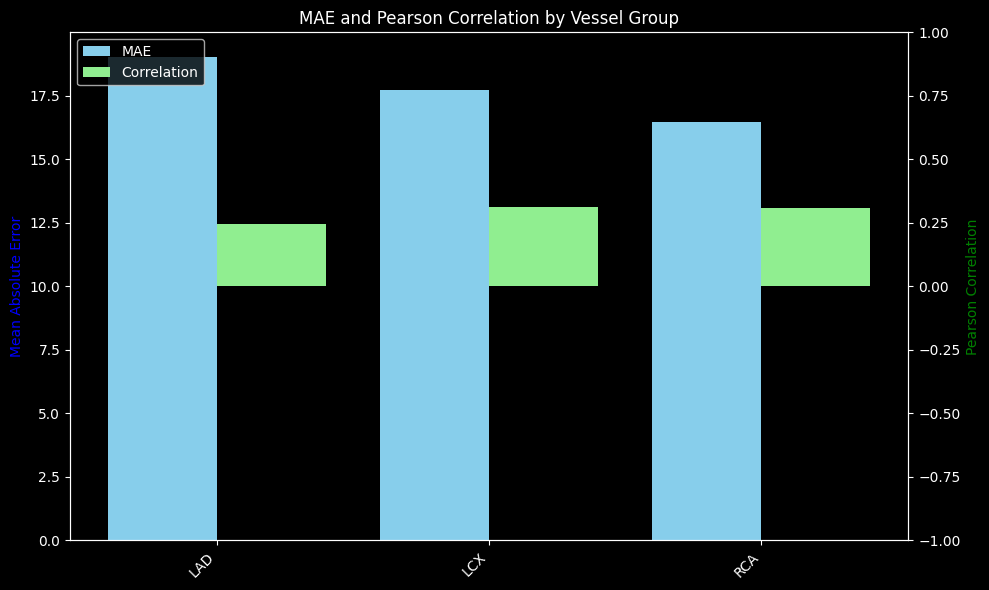

outputs/deepCORO_CLIP/DeepCORO_Clip_Sweep_Learnable_Temp_Full_mvit_b10_f16_RAdam_lr2.0874579212751523e-05_20250127-000603_55mjqoj9/val_epoch1.csv
Mean Absolute Error for individual vessels:
  lad_stenosis: MAE = 25.42
  dist_lad_stenosis: MAE = 10.72
  mid_lad_stenosis: MAE = 26.79
  lcx_stenosis: MAE = 21.40
  dist_lcx_stenosis: MAE = 19.13
  leftmain_stenosis: MAE = 14.30
  prox_rca_stenosis: MAE = 21.42
  mid_rca_stenosis: MAE = 23.44
  dist_rca_stenosis: MAE = 15.25
  posterolateral_stenosis: MAE = 9.81
  pda_stenosis: MAE = 13.57

Mean Absolute Error for vessel groups:
  LAD: MAE = 20.98
  LCX: MAE = 18.28
  RCA: MAE = 16.70

Average MAE across epicardial vessels: 18.65
Average correlation across epicardial vessels: 0.28

Coronary Dominance Accuracy: 71.85%


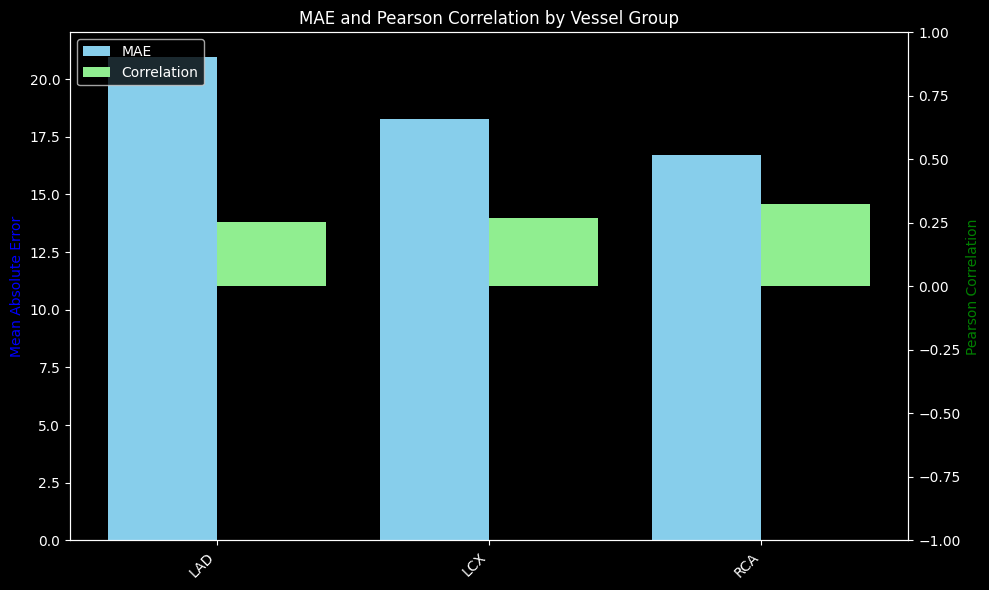

outputs/deepCORO_CLIP/DeepCORO_Clip_Sweep_Learnable_Temp_Full_mvit_b10_f16_RAdam_lr2.0874579212751523e-05_20250127-000603_55mjqoj9/val_epoch2.csv
Mean Absolute Error for individual vessels:
  lad_stenosis: MAE = 23.08
  dist_lad_stenosis: MAE = 8.34
  mid_lad_stenosis: MAE = 24.65
  lcx_stenosis: MAE = 19.60
  dist_lcx_stenosis: MAE = 17.95
  leftmain_stenosis: MAE = 12.22
  prox_rca_stenosis: MAE = 21.41
  mid_rca_stenosis: MAE = 20.59
  dist_rca_stenosis: MAE = 13.30
  posterolateral_stenosis: MAE = 6.78
  pda_stenosis: MAE = 10.12

Mean Absolute Error for vessel groups:
  LAD: MAE = 18.69
  LCX: MAE = 16.59
  RCA: MAE = 14.44

Average MAE across epicardial vessels: 16.57
Average correlation across epicardial vessels: 0.32

Coronary Dominance Accuracy: 75.40%


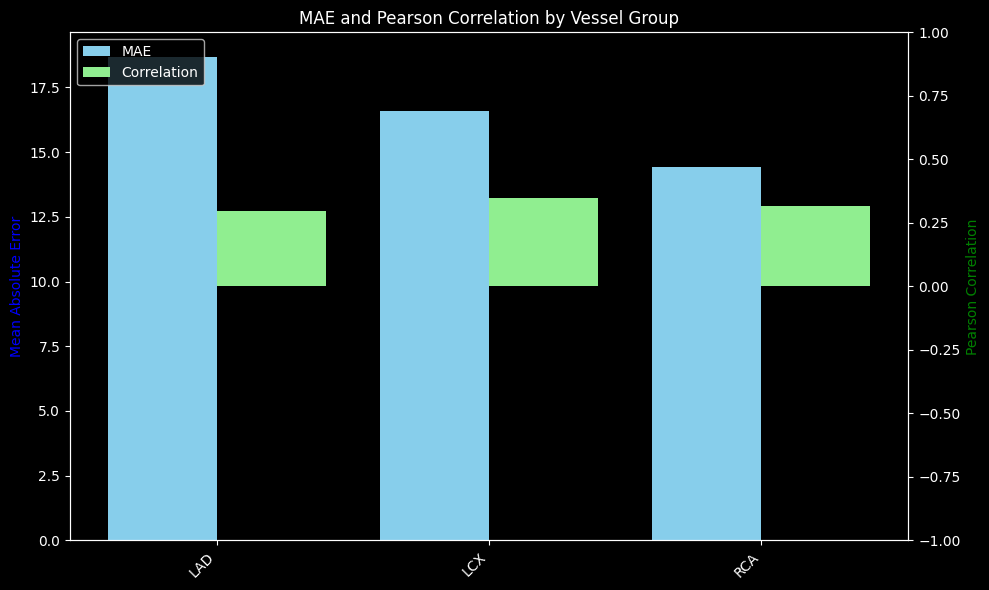

outputs/deepCORO_CLIP/DeepCORO_Clip_Sweep_Learnable_Temp_Full_mvit_b10_f16_RAdam_lr2.0874579212751523e-05_20250127-000603_55mjqoj9/val_epoch3.csv
Mean Absolute Error for individual vessels:
  lad_stenosis: MAE = 23.33
  dist_lad_stenosis: MAE = 9.30
  mid_lad_stenosis: MAE = 24.98
  lcx_stenosis: MAE = 19.86
  dist_lcx_stenosis: MAE = 19.08
  leftmain_stenosis: MAE = 12.09
  prox_rca_stenosis: MAE = 19.77
  mid_rca_stenosis: MAE = 18.75
  dist_rca_stenosis: MAE = 13.04
  posterolateral_stenosis: MAE = 7.69
  pda_stenosis: MAE = 10.91

Mean Absolute Error for vessel groups:
  LAD: MAE = 19.20
  LCX: MAE = 17.01
  RCA: MAE = 14.03

Average MAE across epicardial vessels: 16.75
Average correlation across epicardial vessels: 0.34

Coronary Dominance Accuracy: 83.77%


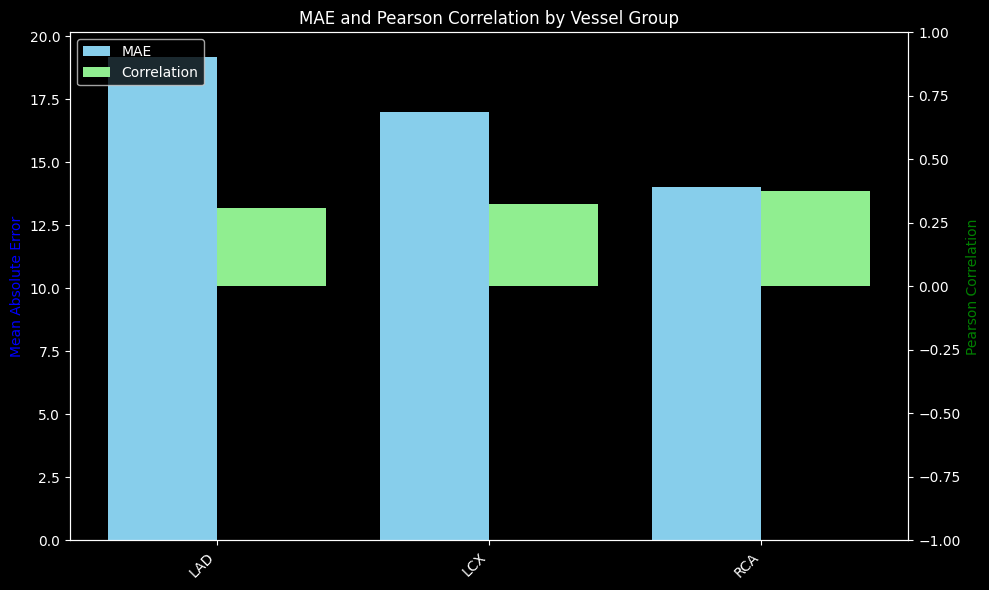

outputs/deepCORO_CLIP/DeepCORO_Clip_Sweep_Learnable_Temp_Full_mvit_b10_f16_RAdam_lr2.0874579212751523e-05_20250127-000603_55mjqoj9/val_epoch4.csv
Mean Absolute Error for individual vessels:
  lad_stenosis: MAE = 25.54
  dist_lad_stenosis: MAE = 8.44
  mid_lad_stenosis: MAE = 25.82
  lcx_stenosis: MAE = 20.70
  dist_lcx_stenosis: MAE = 19.02
  leftmain_stenosis: MAE = 13.02
  prox_rca_stenosis: MAE = 19.79
  mid_rca_stenosis: MAE = 18.53
  dist_rca_stenosis: MAE = 11.92
  posterolateral_stenosis: MAE = 7.06
  pda_stenosis: MAE = 9.99

Mean Absolute Error for vessel groups:
  LAD: MAE = 19.93
  LCX: MAE = 17.58
  RCA: MAE = 13.46

Average MAE across epicardial vessels: 16.99
Average correlation across epicardial vessels: 0.32

Coronary Dominance Accuracy: 84.03%


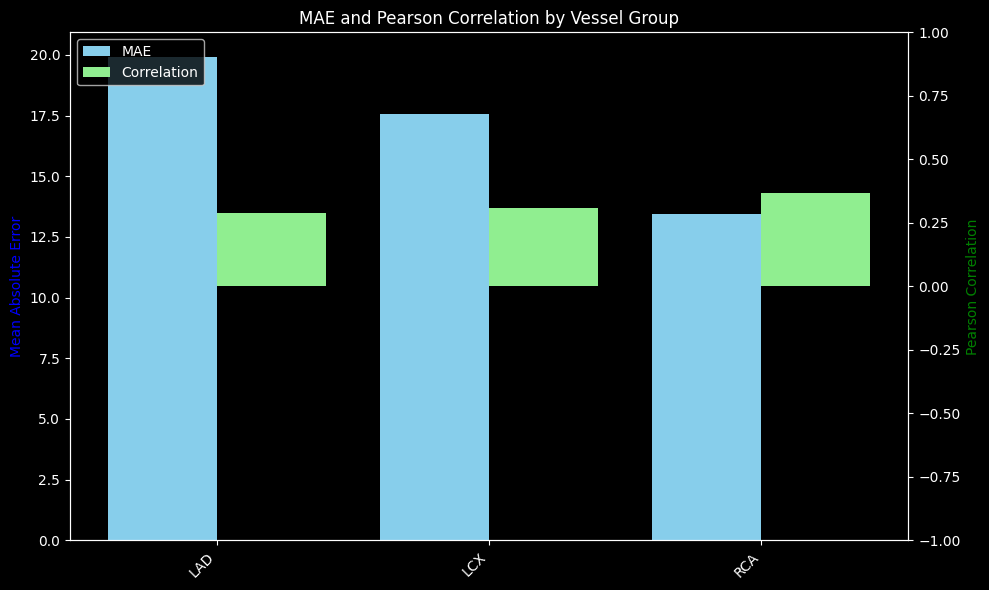

outputs/deepCORO_CLIP/DeepCORO_Clip_Sweep_Learnable_Temp_Full_mvit_b10_f16_RAdam_lr2.0874579212751523e-05_20250127-000603_55mjqoj9/val_epoch5.csv
Mean Absolute Error for individual vessels:
  lad_stenosis: MAE = 24.56
  dist_lad_stenosis: MAE = 8.41
  mid_lad_stenosis: MAE = 25.63
  lcx_stenosis: MAE = 20.34
  dist_lcx_stenosis: MAE = 18.88
  leftmain_stenosis: MAE = 12.86
  prox_rca_stenosis: MAE = 19.79
  mid_rca_stenosis: MAE = 19.67
  dist_rca_stenosis: MAE = 13.67
  posterolateral_stenosis: MAE = 8.32
  pda_stenosis: MAE = 11.52

Mean Absolute Error for vessel groups:
  LAD: MAE = 19.53
  LCX: MAE = 17.36
  RCA: MAE = 14.59

Average MAE across epicardial vessels: 17.16
Average correlation across epicardial vessels: 0.34

Coronary Dominance Accuracy: 87.21%


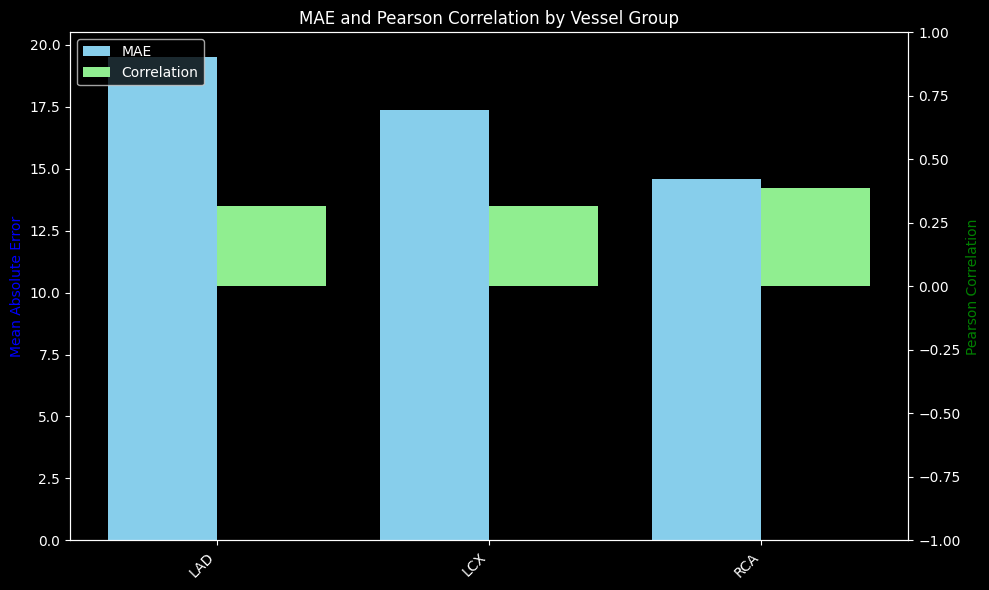

outputs/deepCORO_CLIP/DeepCORO_Clip_Sweep_Learnable_Temp_Full_mvit_b10_f16_RAdam_lr2.0874579212751523e-05_20250127-000603_55mjqoj9/val_epoch6.csv
Mean Absolute Error for individual vessels:
  lad_stenosis: MAE = 23.57
  dist_lad_stenosis: MAE = 8.27
  mid_lad_stenosis: MAE = 24.68
  lcx_stenosis: MAE = 19.95
  dist_lcx_stenosis: MAE = 18.20
  leftmain_stenosis: MAE = 12.53
  prox_rca_stenosis: MAE = 18.97
  mid_rca_stenosis: MAE = 18.76
  dist_rca_stenosis: MAE = 11.91
  posterolateral_stenosis: MAE = 7.62
  pda_stenosis: MAE = 11.21

Mean Absolute Error for vessel groups:
  LAD: MAE = 18.84
  LCX: MAE = 16.89
  RCA: MAE = 13.69

Average MAE across epicardial vessels: 16.47
Average correlation across epicardial vessels: 0.35

Coronary Dominance Accuracy: 88.22%


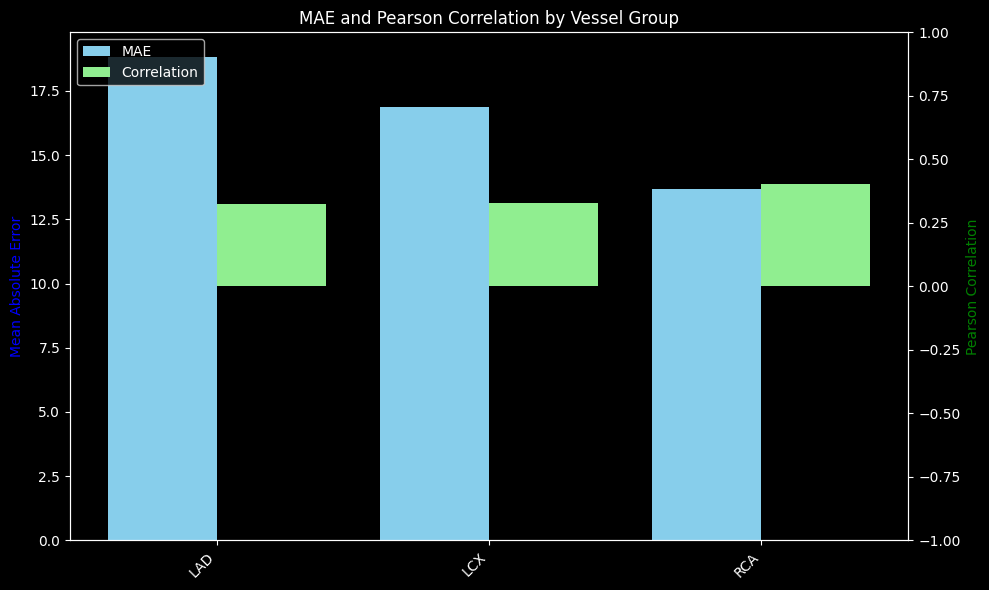

outputs/deepCORO_CLIP/DeepCORO_Clip_Sweep_Learnable_Temp_Full_mvit_b10_f16_RAdam_lr2.0874579212751523e-05_20250127-000603_55mjqoj9/val_epoch7.csv
Mean Absolute Error for individual vessels:
  lad_stenosis: MAE = 26.10
  dist_lad_stenosis: MAE = 9.34
  mid_lad_stenosis: MAE = 25.78
  lcx_stenosis: MAE = 21.28
  dist_lcx_stenosis: MAE = 19.84
  leftmain_stenosis: MAE = 13.06
  prox_rca_stenosis: MAE = 19.25
  mid_rca_stenosis: MAE = 18.33
  dist_rca_stenosis: MAE = 11.89
  posterolateral_stenosis: MAE = 8.62
  pda_stenosis: MAE = 12.83

Mean Absolute Error for vessel groups:
  LAD: MAE = 20.40
  LCX: MAE = 18.06
  RCA: MAE = 14.18

Average MAE across epicardial vessels: 17.55
Average correlation across epicardial vessels: 0.34

Coronary Dominance Accuracy: 90.99%


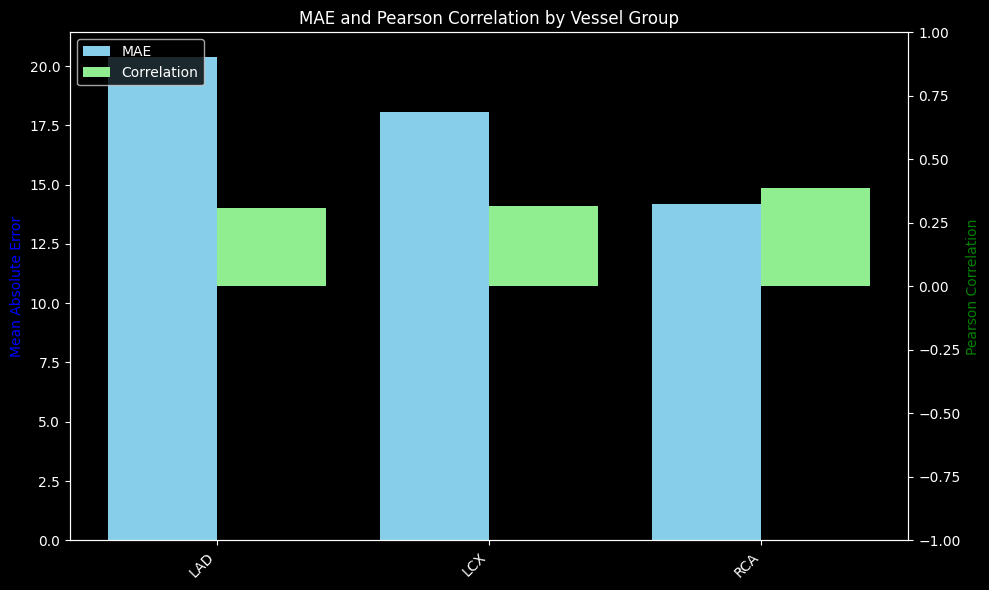

outputs/deepCORO_CLIP/DeepCORO_Clip_Sweep_Learnable_Temp_Full_mvit_b10_f16_RAdam_lr2.0874579212751523e-05_20250127-000603_55mjqoj9/val_epoch8.csv
Mean Absolute Error for individual vessels:
  lad_stenosis: MAE = 25.81
  dist_lad_stenosis: MAE = 8.63
  mid_lad_stenosis: MAE = 24.73
  lcx_stenosis: MAE = 21.07
  dist_lcx_stenosis: MAE = 19.55
  leftmain_stenosis: MAE = 11.66
  prox_rca_stenosis: MAE = 19.59
  mid_rca_stenosis: MAE = 19.47
  dist_rca_stenosis: MAE = 11.90
  posterolateral_stenosis: MAE = 8.21
  pda_stenosis: MAE = 11.25

Mean Absolute Error for vessel groups:
  LAD: MAE = 19.72
  LCX: MAE = 17.43
  RCA: MAE = 14.09

Average MAE across epicardial vessels: 17.08
Average correlation across epicardial vessels: 0.34

Coronary Dominance Accuracy: 88.05%


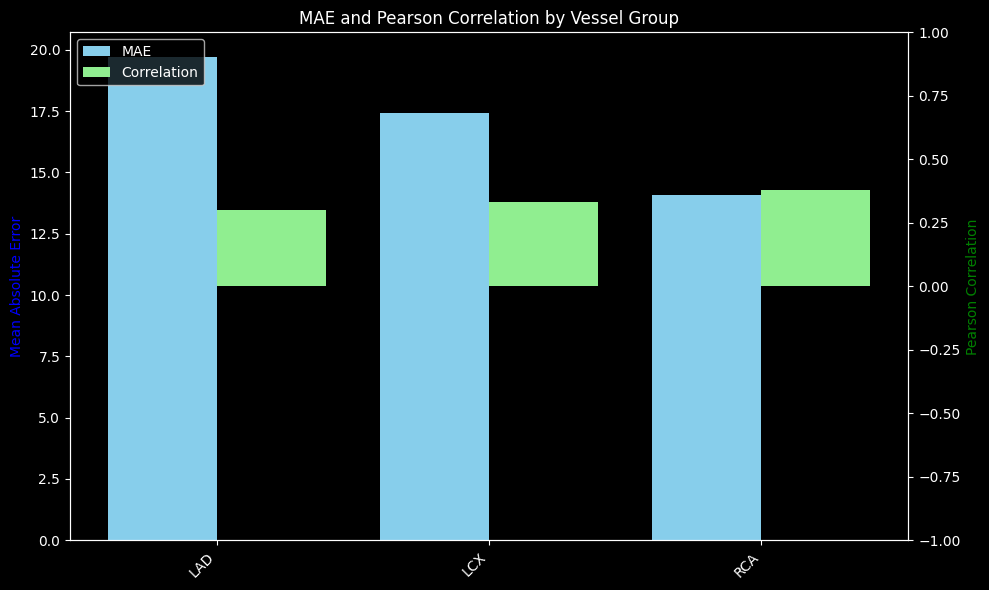

outputs/deepCORO_CLIP/DeepCORO_Clip_Sweep_Learnable_Temp_Full_mvit_b10_f16_RAdam_lr2.0874579212751523e-05_20250127-000603_55mjqoj9/val_epoch9.csv
Mean Absolute Error for individual vessels:
  lad_stenosis: MAE = 24.23
  dist_lad_stenosis: MAE = 8.77
  mid_lad_stenosis: MAE = 24.03
  lcx_stenosis: MAE = 20.73
  dist_lcx_stenosis: MAE = 19.74
  leftmain_stenosis: MAE = 11.52
  prox_rca_stenosis: MAE = 18.83
  mid_rca_stenosis: MAE = 18.61
  dist_rca_stenosis: MAE = 11.69
  posterolateral_stenosis: MAE = 8.19
  pda_stenosis: MAE = 11.02

Mean Absolute Error for vessel groups:
  LAD: MAE = 19.01
  LCX: MAE = 17.33
  RCA: MAE = 13.67

Average MAE across epicardial vessels: 16.67
Average correlation across epicardial vessels: 0.37

Coronary Dominance Accuracy: 88.19%


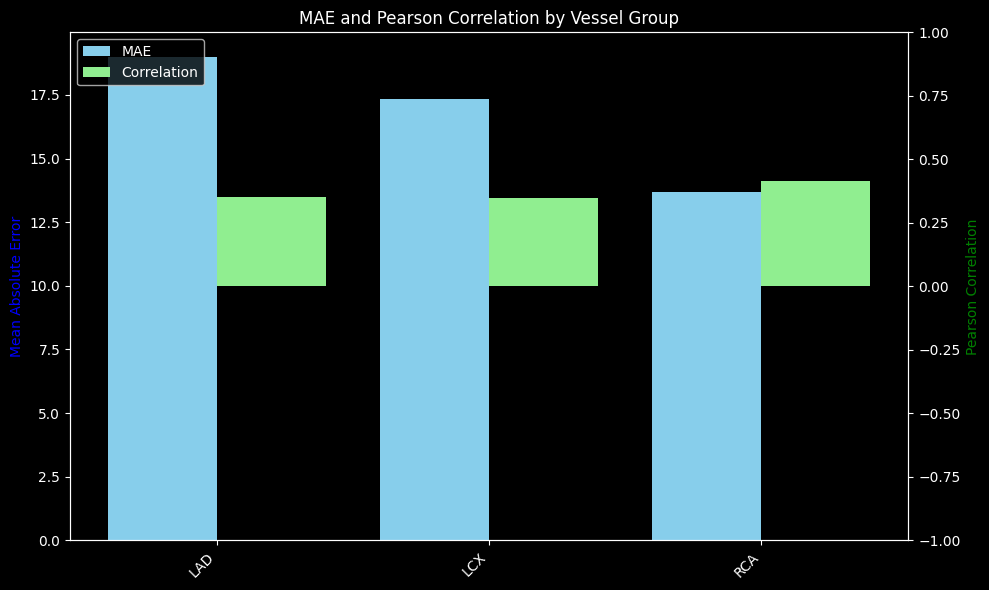

outputs/deepCORO_CLIP/DeepCORO_Clip_Sweep_Learnable_Temp_Full_mvit_b10_f16_RAdam_lr2.0874579212751523e-05_20250127-000603_55mjqoj9/val_epoch10.csv
Mean Absolute Error for individual vessels:
  lad_stenosis: MAE = 24.69
  dist_lad_stenosis: MAE = 8.33
  mid_lad_stenosis: MAE = 24.03
  lcx_stenosis: MAE = 19.66
  dist_lcx_stenosis: MAE = 16.93
  leftmain_stenosis: MAE = 10.38
  prox_rca_stenosis: MAE = 18.88
  mid_rca_stenosis: MAE = 17.85
  dist_rca_stenosis: MAE = 11.00
  posterolateral_stenosis: MAE = 7.25
  pda_stenosis: MAE = 10.99

Mean Absolute Error for vessel groups:
  LAD: MAE = 19.01
  LCX: MAE = 15.66
  RCA: MAE = 13.19

Average MAE across epicardial vessels: 15.95
Average correlation across epicardial vessels: 0.36

Coronary Dominance Accuracy: 87.38%


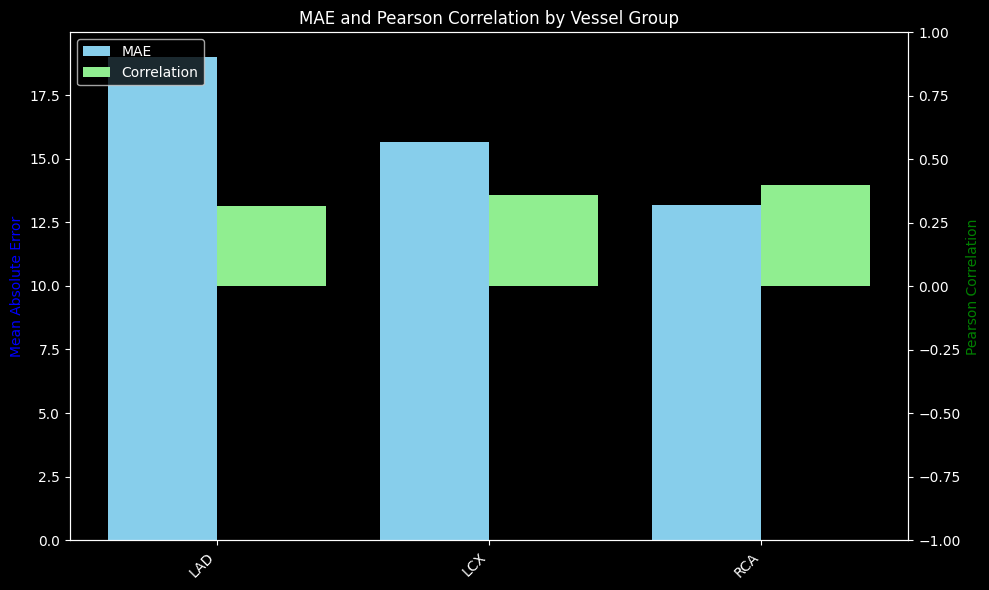

outputs/deepCORO_CLIP/DeepCORO_Clip_Sweep_Learnable_Temp_Full_mvit_b10_f16_RAdam_lr2.0874579212751523e-05_20250127-000603_55mjqoj9/val_epoch11.csv
Mean Absolute Error for individual vessels:
  lad_stenosis: MAE = 23.30
  dist_lad_stenosis: MAE = 8.17
  mid_lad_stenosis: MAE = 23.71
  lcx_stenosis: MAE = 19.77
  dist_lcx_stenosis: MAE = 17.96
  leftmain_stenosis: MAE = 10.26
  prox_rca_stenosis: MAE = 18.61
  mid_rca_stenosis: MAE = 17.95
  dist_rca_stenosis: MAE = 12.31
  posterolateral_stenosis: MAE = 7.29
  pda_stenosis: MAE = 10.58

Mean Absolute Error for vessel groups:
  LAD: MAE = 18.39
  LCX: MAE = 16.00
  RCA: MAE = 13.35

Average MAE across epicardial vessels: 15.91
Average correlation across epicardial vessels: 0.38

Coronary Dominance Accuracy: 88.91%


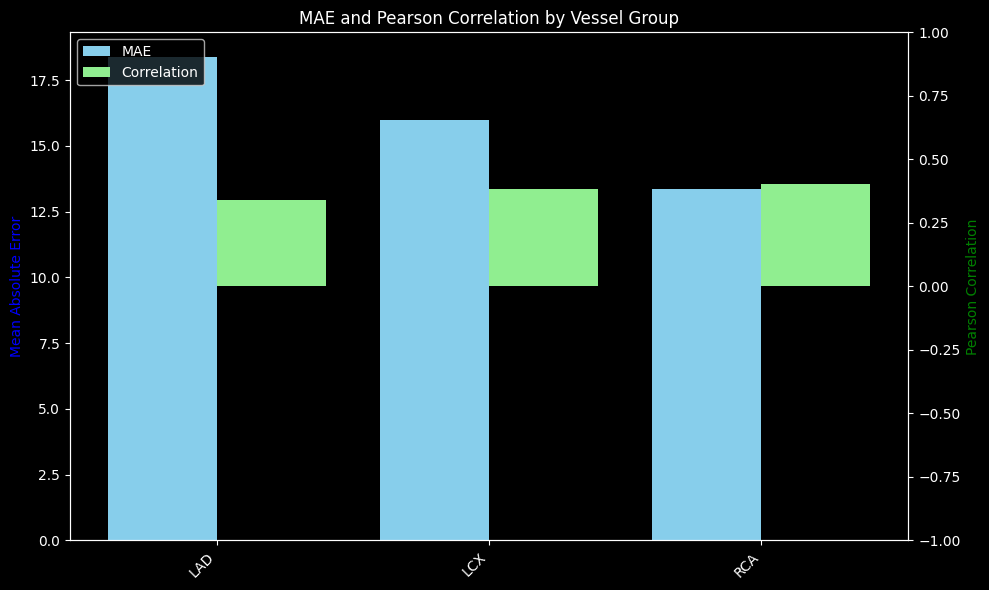

outputs/deepCORO_CLIP/DeepCORO_Clip_Sweep_Learnable_Temp_Full_mvit_b10_f16_RAdam_lr2.0874579212751523e-05_20250127-000603_55mjqoj9/val_epoch12.csv
Mean Absolute Error for individual vessels:
  lad_stenosis: MAE = 23.21
  dist_lad_stenosis: MAE = 8.80
  mid_lad_stenosis: MAE = 22.66
  lcx_stenosis: MAE = 21.24
  dist_lcx_stenosis: MAE = 19.64
  leftmain_stenosis: MAE = 10.29
  prox_rca_stenosis: MAE = 18.62
  mid_rca_stenosis: MAE = 17.49
  dist_rca_stenosis: MAE = 11.08
  posterolateral_stenosis: MAE = 7.41
  pda_stenosis: MAE = 11.05

Mean Absolute Error for vessel groups:
  LAD: MAE = 18.22
  LCX: MAE = 17.06
  RCA: MAE = 13.13

Average MAE across epicardial vessels: 16.14
Average correlation across epicardial vessels: 0.38

Coronary Dominance Accuracy: 87.99%


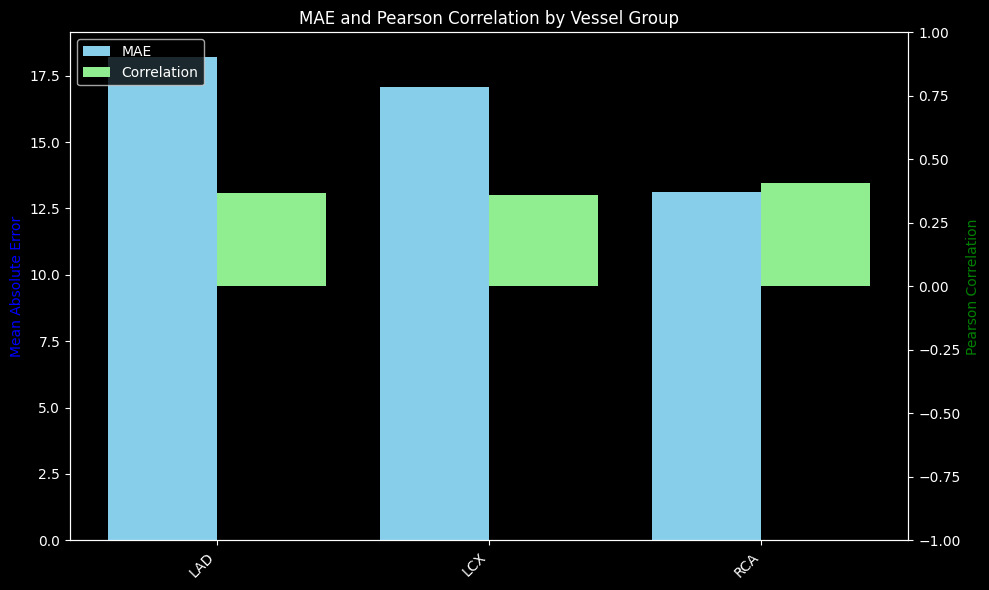

outputs/deepCORO_CLIP/DeepCORO_Clip_Sweep_Learnable_Temp_Full_mvit_b10_f16_RAdam_lr2.0874579212751523e-05_20250127-000603_55mjqoj9/val_epoch13.csv
Mean Absolute Error for individual vessels:
  lad_stenosis: MAE = 23.12
  dist_lad_stenosis: MAE = 8.68
  mid_lad_stenosis: MAE = 22.99
  lcx_stenosis: MAE = 20.15
  dist_lcx_stenosis: MAE = 18.49
  leftmain_stenosis: MAE = 9.74
  prox_rca_stenosis: MAE = 18.51
  mid_rca_stenosis: MAE = 18.08
  dist_rca_stenosis: MAE = 12.20
  posterolateral_stenosis: MAE = 8.54
  pda_stenosis: MAE = 12.02

Mean Absolute Error for vessel groups:
  LAD: MAE = 18.26
  LCX: MAE = 16.12
  RCA: MAE = 13.87

Average MAE across epicardial vessels: 16.09
Average correlation across epicardial vessels: 0.40

Coronary Dominance Accuracy: 88.91%


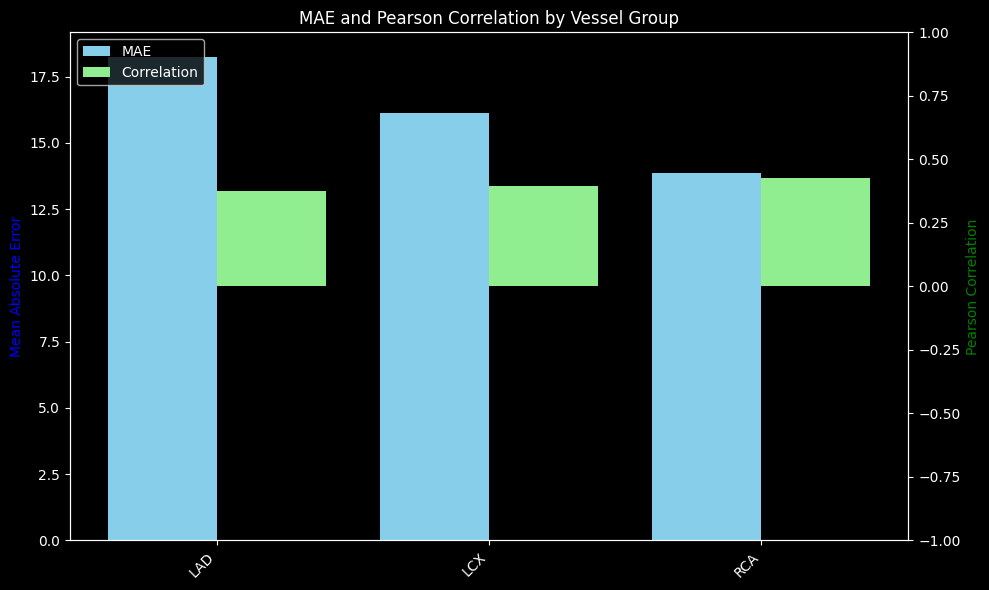

outputs/deepCORO_CLIP/DeepCORO_Clip_Sweep_Learnable_Temp_Full_mvit_b10_f16_RAdam_lr2.0874579212751523e-05_20250127-000603_55mjqoj9/val_epoch14.csv


In [ ]:
### Plot metrics across epochs ###
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt

# Get base folder path from the example path
base_folder = "outputs/deepCORO_CLIP/DeepCORO_Clip_Sweep_Learnable_Temp_Full_mvit_b10_f16_RAdam_lr2.0874579212751523e-05_20250127-000603_55mjqoj9/"
unique_texts_csv = os.path.join(base_folder, "val_texts.csv")

# Get all val_epoch files and extract epoch numbers
val_files = glob.glob(os.path.join(base_folder, "val_epoch*.csv"))
epoch_nums = []
avg_maes = []
avg_corrs = []
dominance_accs = []

for val_file in sorted(val_files, key=lambda x: int(re.findall(r'epoch(\d+)', x)[0])):
    print(val_file)
    epoch_num = int(re.findall(r'epoch(\d+)', val_file)[0])
    
    # Get metrics for this epoch
    merged_df, mae_values, corr_values, group_mae_values, group_corr_valuess = plot_vessel_metrics(
        df_dataset,
        val_file,
        unique_texts_csv,
        labels_to_vessel_names,
        mode_with_mean_on_tie=False,
        topk=5
    )   
    # Store results
    epoch_nums.append(epoch_num)
    avg_maes.append(np.mean(list(mae_values.values())))
    avg_corrs.append(np.mean(list(corr_values.values())))
    if "dominance_correct" in merged_df.columns:
        dominance_accs.append(merged_df["dominance_correct"].mean())

# Plot metrics over epochs
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

ax1.plot(epoch_nums, avg_maes, 'b-o')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Average MAE')
ax1.set_title('Average MAE vs Epoch')
ax1.grid(True)

ax2.plot(epoch_nums, avg_corrs, 'g-o')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Average Pearson Correlation')
ax2.set_title('Average Correlation vs Epoch')
ax2.grid(True)

if dominance_accs:
    ax3.plot(epoch_nums, dominance_accs, 'r-o')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Dominance Accuracy')
    ax3.set_title('Dominance Accuracy vs Epoch')
    ax3.grid(True)

plt.tight_layout()
plt.show()